<H1>Необходимо предсказать верхнюю границу заработной платы (salary_to) для вакансии</H1>

In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from datetime import datetime, timedelta, date
import warnings
warnings.filterwarnings('ignore')
from tqdm.auto import tqdm
tqdm.pandas()

from IPython.core.display import display, HTML
display(HTML("<style>.container {width:100% !important;}</style>"))

import xlrd
from itertools import chain
pd.set_option('display.max_colwidth', None)

Считываем данные для обучения:

In [2]:
pd.options.display.max_rows = 2

df = pd.read_csv('X_train.csv', parse_dates=['published_at', 'created_at'])

#df
#df.describe()

Считываем значения salary_to для данных для обучения и мерджим с предыдущей таблицей

In [3]:
df1 = pd.read_csv('y_train.csv')
df = df.set_index('id').join(df1.set_index('id'))
#df

<H1>Исследование данных / Data exploration</H1>

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27934 entries, 29083 to 15795
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype              
---  ------                    --------------  -----              
 0   name                      27934 non-null  object             
 1   has_test                  27934 non-null  bool               
 2   response_letter_required  27934 non-null  bool               
 3   salary_from               23902 non-null  float64            
 4   salary_currency           27934 non-null  object             
 5   salary_gross              27786 non-null  object             
 6   published_at              27934 non-null  datetime64[ns, UTC]
 7   created_at                27934 non-null  datetime64[ns, UTC]
 8   employer_name             27934 non-null  object             
 9   description               27933 non-null  object             
 10  area_id                   27934 non-null  int64              
 11  area_name       

Три колонки имеют пустоты: salary_from, salary_gross, и у 1-го нет description

In [5]:
pd.options.display.max_rows = 13
df.describe(include='O')

,name,salary_currency,salary_gross,employer_name,description,area_name
count,27934,27934,27786,27934,27933,27934
unique,16395,1,2,13318,23681,156
top,Менеджер по продажам,RUR,False,Пятёрочка,"<p><strong>Обязанности:</strong></p><ul><li>Обслуживание покупателей на кассе (наличный и безналичный расчет)</li><li>Выкладка товара в зале</li><li>Отслеживание сроков годности товара</li><li>Проверка наличия ценников</li><li>Консультация покупателей в зале</li></ul><p><strong>Требования:</strong></p><ul><li>Ответственность, дисциплинированность, внимательность</li></ul><p><strong>Условия:</strong></p><ul><li>График работы 5/2, 2/2, возможен неполный рабочий день, неполная рабочая неделя</li><li>Возможность подработки (работа по совместительству)</li><li>Социальные гарантии, оплата отпусков и больничных листов</li><li>Работа рядом с домом</li><li>Скидки в магазинах сети</li><li>Фирменная спецодежда</li><li>Возможность профессионального и карьерного роста, корпоративное обучение</li><li>Корпоративные мероприятия и конкурсы</li></ul>",Москва
freq,337,27934,18726,927,624,20512


<H1>Категориальные / Category</H1>

Во первых, колонка description выглядит сложной и ненужной, отбросим её

In [6]:
import re
df['description'] = pd.Series(df['description'],dtype=pd.StringDtype())
df.description = df.description.apply(lambda x: str(x).lower())
df.description = df.description.apply(lambda x: re.sub(r'</?[A-Za-z0-9]+ ?/?>', ' ', str(x)))

In [7]:
def manage_desc(string):
    #print(string)
    pattern = r'[0-9][0-9.,тыс ]+[0-9 ]руб.?\/?[а-яА-Я ]*([0-9 ]+час)?(час)?(мес)?(день)?'
    max_salary = -1
    for match_raw in re.finditer(pattern, string):
        number = ''
        match = match_raw.group()
        #print(match)
        first_numeric_found = False
        for ch in match:
            if ch.isnumeric():
                number += ch
                first_numeric_found = True
            elif ch == ' ' or ch == ',' or ch == '.':
                pass
            else:
                if first_numeric_found:
                    break
        salary = int(number)
        if 'сут' in match or 'день' in match:
            salary *= 20
        elif 'час' in match:
            salary *= 160

        if 'тыс' in match or 'т.' in match:
            salary *= 1000
        
        if max_salary == -1 or salary > max_salary:
            max_salary = salary
    
    if (max_salary < 1000):
        return -1
    else:
        return max_salary

#manage_desc(df['description'][23187])

In [8]:
df.description = df.description.map(manage_desc)

In [9]:
df.description.value_counts()

description
-1         23134
 40000       354
 50000       331
 60000       312
 30000       269
           ...  
 51200         1
 42400         1
 61600         1
 204000        1
 25500         1
Name: count, Length: 355, dtype: int64

In [10]:
df.description = df.description.apply(lambda x: df.description.min() if x == -1 else x)

In [11]:
#df = df.drop(columns=['description'])

Далее, salary_currency имеет unique=1, значит эту колонку можно удалить

In [12]:
df = df.drop(columns=['salary_currency'])

Столбцы published_at и created_at выглядят одинаковыми, проверим

In [13]:
(df['published_at']==df['created_at']).value_counts()

True    27934
Name: count, dtype: int64

Таким образом, столбцы published_at и created_at напрямую коррелируют, значит один из них можно отбросить

In [14]:
df = df.drop(columns=['created_at'])

In [15]:
df.describe(include='O')

,name,salary_gross,employer_name,area_name
count,27934,27786,27934,27934
unique,16395,2,13318,156
top,Менеджер по продажам,False,Пятёрочка,Москва
freq,337,18726,927,20512


Оставшиеся 3 столбца: name, employer_name и area_name имеют достаточно много уникальных значений.

Начнем с area_name

In [16]:
pd.options.display.max_rows = 20
df['area_name'].value_counts()

area_name
Москва                         20512
Санкт-Петербург                 5393
Новосибирск                      201
Краснодар                        178
Екатеринбург                     158
                               ...  
Каменск-Шахтинский                 1
Стерлитамак                        1
Турция                             1
Донецк (Ростовская область)        1
Курган                             1
Name: count, Length: 156, dtype: int64

Во первых, в таблице есть area_id, который напрямую коррелирует с area_name. Удалим его

In [17]:
df['area_id'].value_counts()

area_id
1       20512
2        5393
4         201
53        178
3         158
        ...  
1540        1
1364        1
94          1
1537        1
55          1
Name: count, Length: 156, dtype: int64

In [18]:
df = df.drop(columns=['area_id'])

Далее, выделим три типа area: Москва, СП и другие.

In [19]:
df.loc[df["area_name"].value_counts()[df["area_name"]].values < 200, "area_name"] = "Other"
df['area_name'].value_counts()

area_name
Москва             20512
Санкт-Петербург     5393
Other               1828
Новосибирск          201
Name: count, dtype: int64

In [20]:
df

,name,has_test,response_letter_required,salary_from,salary_gross,published_at,employer_name,description,area_name,salary_to
id,,,,,,,,,,
29083,Менеджер по продажам (брокер) элитной городской недвижимости,False,False,NaN,False,2020-06-16 06:45:04+00:00,Villagio Estate,-1,Москва,200000.0
26052,Product marketing manager / Продуктовый маркетолог,False,False,120000.0,False,2020-07-22 10:24:15+00:00,CityAds Media,-1,Москва,170000.0
24055,Программист Python (Middle),False,False,NaN,False,2020-04-12 08:19:08+00:00,Лендсбэй,-1,Москва,120000.0
4408,"Продавец-кассир (Москва, Вернадского, 93)",False,False,33500.0,True,2020-08-24 01:16:52+00:00,Пятёрочка,-1,Москва,38000.0
16856,Дизайнер-визуализатор,False,True,30000.0,True,2021-09-18 13:30:15+00:00,Моллдекор Рус,-1,Москва,35000.0
...,...,...,...,...,...,...,...,...,...,...
16850,Директор департамента по административной и кадровой работе,False,False,120000.0,False,2021-10-03 10:04:45+00:00,Балтик Граунд Сервисес РУ,-1,Москва,150000.0
6265,"Продавец-кассир (г Москва, ул Смольная, д 67 к 2)",False,False,33500.0,True,2020-09-07 00:32:00+00:00,Пятёрочка,-1,Москва,38000.0
11284,Младший аналитик данных,False,False,50000.0,False,2021-04-20 08:25:44+00:00,Баскаков Дмитрий Владимирович,-1,Москва,70000.0


Далее посмотрим на employer_name

In [21]:
df['employer_name'].value_counts()

employer_name
Пятёрочка                    927
Пятерочка                    669
Перекресток                  324
Билайн                       261
JCat.ru                       70
                            ... 
Торговая группа ПТК            1
LTG Consulting                 1
ExMail                         1
Албаков Руслан Борисович       1
Балтик Граунд Сервисес РУ      1
Name: count, Length: 13318, dtype: int64

Во первых, можно увидеть два разных написания "Пятерочка", оставим одно:

In [22]:
df = df.replace(to_replace ="Пятерочка", value ="Пятёрочка") 

df.employer_name.unique()

array(['Villagio Estate', 'CityAds Media', 'Лендсбэй', ...,
       'Харчевников Александр Андреевич', 'RedStone Capital',
       'Балтик Граунд Сервисес РУ'], dtype=object)

In [23]:
df['employer_name'].value_counts()

employer_name
Пятёрочка                    1596
Перекресток                   324
Билайн                        261
JCat.ru                        70
Skyeng                         63
                             ... 
Торговая группа ПТК             1
LTG Consulting                  1
ExMail                          1
Албаков Руслан Борисович        1
Балтик Граунд Сервисес РУ       1
Name: count, Length: 13317, dtype: int64

In [24]:
df.employer_name = df.employer_name.apply(lambda x: x.lower())

In [25]:
df.employer_name = df.employer_name.apply(lambda x: "personname" if (x.endswith('вич') or x.endswith('вна') or x.endswith('вич)') or x.endswith('вна)') or x.startswith('ип') or '(ип ' in x) else x)
df.employer_name = df.employer_name.apply(lambda x: "мвд" if 'мвд' in x else x)

In [26]:
#f = open("emplyer_name.txt", "w")
#np.savetxt("employer_name7.txt", df.employer_name.unique(), fmt='%s');
#f.write()
#f.close()
df['employer_name'].value_counts()

employer_name
personname                   1755
пятёрочка                    1596
перекресток                   324
билайн                        261
мвд                           119
                             ... 
kloombis                        1
кофе1                           1
увелка ооо «ресурс»             1
ассоциация сро оау лидер        1
балтик граунд сервисес ру       1
Name: count, Length: 11936, dtype: int64

Здесь мы сделаем также, как и с area_name:

In [27]:
df.loc[df["employer_name"].value_counts()[df["employer_name"]].values < 100, "employer_name"] = "Other"
df['employer_name'].value_counts()

employer_name
Other          23879
personname      1755
пятёрочка       1596
перекресток      324
билайн           261
мвд              119
Name: count, dtype: int64

Теперь рассмотрим последний столбец: name

In [28]:
df['name'].value_counts()

name
Менеджер по продажам                                   337
Менеджер по работе с клиентами                         201
Юрист                                                  162
Помощник юриста                                        149
Аналитик                                               145
                                                      ... 
Бизнес-аналитик(Внедренец/ Ведущий бизнес-аналитик)      1
Руководитель департамента коммерческой недвижимости      1
Логист- оператор / Грузчик (ТРК Европолис)               1
User Acquisition Manager                                 1
Копирайтер / контент менеджер                            1
Name: count, Length: 16395, dtype: int64

Можно увидеть перечисления через /, либо доп. указания в скобках. Уберем их:

In [29]:
#df = pd.concat([df, df.name.str.split('(', expand=True)[0]\
#                .rename('name_new')], axis=1)
#df = pd.concat([df, df.name_new.str.split('/', expand=True)[0]\
#                .rename('name_new1')], axis=1)
#df

In [30]:
#df['name_new1'].value_counts()

Можно увидеть, что есть два разных "Менеджер по продажам", видимо, у одного из них есть в конце лишние символы. Уберем:

In [31]:
#df['name_new1'] = df['name_new1'].str.strip()
#df['name_new1'].value_counts()

Можно увидеть ещё менеджеров по проадажам, но конкретных (караксных домов, удаленных). Сделаем их обычными менеджерами по продажам:

In [32]:
#df.loc[(df['name_new1'].str.contains('менеджер', case=False) and df['name_new1'].str.contains('продаж', case=False)).bool(), 'name_new1'] = 'Менеджер по продажам'
#df.name = df.name.apply(lambda x: 'Менеджер по продажам' if (('менеджер' in x or 'Менеджер' in x) and ('продаж' in x or 'Продаж' in x)) else x)
#df['name'].value_counts()

In [33]:
df.name = df.name.apply(lambda x: x.lower())

In [34]:

df.name = df.name.apply(lambda x: 'маркетолог' if ('маркетолог' in x or 'market' in x or 'реклам' in x or 'таргетолог' in x or 'промоутер' in x or 'таркетолог' in x) else x)
df.name = df.name.apply(lambda x: 'менеджер' if ('менеджер' in x or 'manager' in x or 'manager' in x) else x)
df.name = df.name.apply(lambda x: 'бухгалтер' if ('бухгалтер' in x) else x)
df.name = df.name.apply(lambda x: 'юрист' if ('юрист' in x) else x)
df.name = df.name.apply(lambda x: 'директор' if ('директор' in x) else x)
df.name = df.name.apply(lambda x: 'разработчик' if ('разраб' in x or 'программист' in x or 'програмист' in x or 'dev' in x or 'backend' in x or 'frontend' in x or 'back-end' in x or 'front-end' in x or 'senior' in x or 'middle' in x or 'junior' in x or 'lead' in x or 'data' in x or 'верст' in x or 'architect' in x) else x)
df.name = df.name.apply(lambda x: 'продавец' if ('продавец' in x or 'кассир' in x) else x)
df.name = df.name.apply(lambda x: 'администратор' if ('администратор' in x) else x)
df.name = df.name.apply(lambda x: 'дизайнер' if ('дизайн' in x or 'design' in x or 'художник' in x or 'artist' in x) else x)
df.name = df.name.apply(lambda x: 'инженер' if ('инженер' in x or 'engineer' in x or 'инжинер' in x) else x)
df.name = df.name.apply(lambda x: 'аналитик' if ('аналитик' in x or 'analyst' in x) else x)
df.name = df.name.apply(lambda x: 'технолог' if ('технолог ' in x) else x)
df.name = df.name.apply(lambda x: 'райтер' if ('копирайтер' in x or 'перевод' in x or 'translat' in x or 'автор' in x or 'райтер' in x or 'редактор' in x or 'писатель' in x) else x)
df.name = df.name.apply(lambda x: 'медик' if ('врач' in x or 'фармацевт' in x or 'провизор' in x or 'химик' in x or 'биолог' in x or 'медиц' in x or 'стомат' in x or 'терапевт' in x or 'хирург' in x or 'медс' in x or 'психолог' in x) else x)
df.name = df.name.apply(lambda x: 'руководитель' if ('руковод' in x) else x)
df.name = df.name.apply(lambda x: 'hr' if ('hr' in x or 'рекрутер' in x or 'сорсер' in x or 'ресерчер' in x or 'кадровик' in x or 'эйчар' in x or 'интервьюер' in x or 'recruit' in x or 'researcher' in x or 'ресечер' in x) else x)
df.name = df.name.apply(lambda x: 'консультант' if ('консульт' in x) else x)
df.name = df.name.apply(lambda x: 'оператор' if ('оператор' in x) else x)
df.name = df.name.apply(lambda x: 'пекарь' if ('пекарь' in x) else x)
df.name = df.name.apply(lambda x: 'стилист' if ('стилист' in x or 'парик' in x or 'барбер' in x or 'маникюр' in x or 'педикюр' in x or 'косметолог' in x or 'визажист' in x) else x)
df.name = df.name.apply(lambda x: 'уборщик' if ('уборщик' in x or 'уборщица' in x) else x)
df.name = df.name.apply(lambda x: 'курьер' if ('курьер' in x) else x)
df.name = df.name.apply(lambda x: 'управляющий' if ('управляющ' in x or 'заведующ' in x) else x)
df.name = df.name.apply(lambda x: 'водитель' if (' водитель' in x or x.startswith('водитель')) else x)
df.name = df.name.apply(lambda x: 'учитель' if ('учитель' in x or 'препод' in x or 'педагог' in x or 'тьютор' in x or 'воспит' in x or 'репетитор' in x or 'тренер' in x) else x)
df.name = df.name.apply(lambda x: 'координатор' if ('координатор' in x or 'coordinator' in x) else x)
df.name = df.name.apply(lambda x: 'повар' if ('повар' in x or 'шеф' in x or 'пекарь' in x or 'кух' in x or 'кондитер' in x) else x)
df.name = df.name.apply(lambda x: 'бармен' if ('бар' in x) else x)
df.name = df.name.apply(lambda x: 'официант' if ('офици' in x) else x)
df.name = df.name.apply(lambda x: 'qa' if (' qa' in x or x.startswith('qa') or 'тест' in x or 'качеств' in x) else x)
df.name = df.name.apply(lambda x: 'монтажер' if ('монтаж' in x or 'видео' in x) else x)
df.name = df.name.apply(lambda x: 'фотограф' if ('фото' in x) else x)
df.name = df.name.apply(lambda x: 'охрана' if ('охран' in x) else x)
df.name = df.name.apply(lambda x: 'экономист' if ('эконом' in x) else x)
df.name = df.name.apply(lambda x: 'мерчендайзер' if ('мерчендайзер' in x or 'мерчандайзер' in x) else x)
df.name = df.name.apply(lambda x: 'сварщик' if ('сварщик' in x) else x)
df.name = df.name.apply(lambda x: 'слесарь' if ('слесарь' in x or 'механик' in x or 'токарь' in x) else x)
df.name = df.name.apply(lambda x: 'грузчик' if ('грузчик' in x or 'кладов' in x or 'склад' in x or 'комплектовщик' in x) else x)
df.name = df.name.apply(lambda x: 'отделочник' if ('отдело' in x) else x)
df.name = df.name.apply(lambda x: 'аренда' if ('аренд' in x) else x)
df.name = df.name.apply(lambda x: 'стажер' if ('стажер' in x or 'стажёр' in x) else x)
df.name = df.name.apply(lambda x: 'товаровед' if ('товар' in x) else x)
df.name = df.name.apply(lambda x: 'домработник' if ('домраб' in x or 'горнич' in x) else x)
df.name = df.name.apply(lambda x: 'недвижимость' if ('недвиж' in x) else x)
df.name = df.name.apply(lambda x: 'сборщик' if ('сбор' in x) else x)
df.name = df.name.apply(lambda x: 'логист' if ('секрет' in x or 'логист' in x or 'диспетч' in x) else x)
df.name = df.name.apply(lambda x: 'мойщик' if ('мой' in x or 'детейл' in x) else x)
df.name = df.name.apply(lambda x: 'мастер' if ('мастер' in x) else x)
df.name = df.name.apply(lambda x: 'специалист' if ('специалист' in x) else x)
df.name = df.name.apply(lambda x: 'ассистент' if ('ассистент' in x) else x)
df.name = df.name.apply(lambda x: 'архитектор' if ('архитек' in x or 'конструкт' in x) else x)
df.name = df.name.apply(lambda x: 'начальник' if ('начальн' in x) else x)
df.name = df.name.apply(lambda x: 'полиция' if ('полиц' in x or ' след' in x or x.startswith('след') or 'дпс' in x or 'мвд' in x or 'оперу' in x) else x)
df.name = df.name.apply(lambda x: 'представитель' if ('представитель' in x) else x)
df.name = df.name.apply(lambda x: 'техник' if ('техник' in x) else x)
df.name = df.name.apply(lambda x: 'сотрудник' if ('сотрудник' in x) else x)
df.name = df.name.apply(lambda x: 'упаковщик' if ('упаков' in x or 'фасов' in x) else x)
df.name = df.name.apply(lambda x: 'агент' if ('агент' in x) else x)
df['name'].value_counts()

name
разработчик                       5330
менеджер                          4979
продавец                          2209
инженер                           1220
аналитик                           936
                                  ... 
помощник/помощница на даче           1
маляр по дереву                      1
обивщик мебели, распиловщик          1
treasury associate                   1
ученик на швейное производство       1
Name: count, Length: 835, dtype: int64

In [35]:
#np.savetxt("name1.txt", df['name'].value_counts(), fmt='%s');

In [36]:
df.loc[df["name"].value_counts()[df["name"]].values < 100, "name"] = "Other"
df['name'].value_counts()

name
разработчик     5330
менеджер        4979
Other           2488
продавец        2209
инженер         1220
                ... 
мастер           116
полиция          111
ассистент        111
слесарь          106
мерчендайзер     101
Name: count, Length: 34, dtype: int64

Получили более менее нормальные значения фич

In [37]:
df.describe(include='O')

,name,salary_gross,employer_name,area_name
count,27934,27786,27934,27934
unique,34,2,6,4
top,разработчик,False,Other,Москва
freq,5330,18726,23879,20512


name и name_new можно дропнуть

In [38]:
#df['name_new1'] = df['name']
#df

In [39]:
#df = df.drop(columns=['name', 'name_new'])

In [40]:
df.describe(include='O')

,name,salary_gross,employer_name,area_name
count,27934,27786,27934,27934
unique,34,2,6,4
top,разработчик,False,Other,Москва
freq,5330,18726,23879,20512


salary_gross нужно преобразовать из типа object в тип bool

In [41]:
df['salary_gross'] = df['salary_gross'].astype(bool)
df.describe(include='O')

,name,employer_name,area_name
count,27934,27934,27934
unique,34,6,4
top,разработчик,Other,Москва
freq,5330,23879,20512


In [42]:
df

,name,has_test,response_letter_required,salary_from,salary_gross,published_at,employer_name,description,area_name,salary_to
id,,,,,,,,,,
29083,менеджер,False,False,NaN,False,2020-06-16 06:45:04+00:00,Other,-1,Москва,200000.0
26052,маркетолог,False,False,120000.0,False,2020-07-22 10:24:15+00:00,Other,-1,Москва,170000.0
24055,разработчик,False,False,NaN,False,2020-04-12 08:19:08+00:00,Other,-1,Москва,120000.0
4408,продавец,False,False,33500.0,True,2020-08-24 01:16:52+00:00,пятёрочка,-1,Москва,38000.0
16856,дизайнер,False,True,30000.0,True,2021-09-18 13:30:15+00:00,Other,-1,Москва,35000.0
...,...,...,...,...,...,...,...,...,...,...
16850,директор,False,False,120000.0,False,2021-10-03 10:04:45+00:00,Other,-1,Москва,150000.0
6265,продавец,False,False,33500.0,True,2020-09-07 00:32:00+00:00,пятёрочка,-1,Москва,38000.0
11284,аналитик,False,False,50000.0,False,2021-04-20 08:25:44+00:00,personname,-1,Москва,70000.0


<H1>Количественные / Quantitative</H1>

In [43]:
import matplotlib.pyplot as plt

Поместим среднее значение в эти строки:

In [44]:
df.salary_from.fillna(df.salary_from.mean(), inplace = True) 
df

,name,has_test,response_letter_required,salary_from,salary_gross,published_at,employer_name,description,area_name,salary_to
id,,,,,,,,,,
29083,менеджер,False,False,64179.458874,False,2020-06-16 06:45:04+00:00,Other,-1,Москва,200000.0
26052,маркетолог,False,False,120000.000000,False,2020-07-22 10:24:15+00:00,Other,-1,Москва,170000.0
24055,разработчик,False,False,64179.458874,False,2020-04-12 08:19:08+00:00,Other,-1,Москва,120000.0
4408,продавец,False,False,33500.000000,True,2020-08-24 01:16:52+00:00,пятёрочка,-1,Москва,38000.0
16856,дизайнер,False,True,30000.000000,True,2021-09-18 13:30:15+00:00,Other,-1,Москва,35000.0
...,...,...,...,...,...,...,...,...,...,...
16850,директор,False,False,120000.000000,False,2021-10-03 10:04:45+00:00,Other,-1,Москва,150000.0
6265,продавец,False,False,33500.000000,True,2020-09-07 00:32:00+00:00,пятёрочка,-1,Москва,38000.0
11284,аналитик,False,False,50000.000000,False,2021-04-20 08:25:44+00:00,personname,-1,Москва,70000.0


In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27934 entries, 29083 to 15795
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype              
---  ------                    --------------  -----              
 0   name                      27934 non-null  object             
 1   has_test                  27934 non-null  bool               
 2   response_letter_required  27934 non-null  bool               
 3   salary_from               27934 non-null  float64            
 4   salary_gross              27934 non-null  bool               
 5   published_at              27934 non-null  datetime64[ns, UTC]
 6   employer_name             27934 non-null  object             
 7   description               27934 non-null  int64              
 8   area_name                 27934 non-null  object             
 9   salary_to                 27934 non-null  float64            
dtypes: bool(3), datetime64[ns, UTC](1), float64(2), int64(1), object(3)
memory usage: 2

Разберемся с датами

In [46]:
df['published_at_diff'] = df['published_at'].map(lambda x: datetime.now().timestamp() - x.timestamp())
#df_one_hoted = df_one_hoted.drop(columns=['published_at'])

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27934 entries, 29083 to 15795
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype              
---  ------                    --------------  -----              
 0   name                      27934 non-null  object             
 1   has_test                  27934 non-null  bool               
 2   response_letter_required  27934 non-null  bool               
 3   salary_from               27934 non-null  float64            
 4   salary_gross              27934 non-null  bool               
 5   published_at              27934 non-null  datetime64[ns, UTC]
 6   employer_name             27934 non-null  object             
 7   description               27934 non-null  int64              
 8   area_name                 27934 non-null  object             
 9   salary_to                 27934 non-null  float64            
 10  published_at_diff         27934 non-null  float64            
dtypes: bool(3), date

In [48]:
df

,name,has_test,response_letter_required,salary_from,salary_gross,published_at,employer_name,description,area_name,salary_to,published_at_diff
id,,,,,,,,,,,
29083,менеджер,False,False,64179.458874,False,2020-06-16 06:45:04+00:00,Other,-1,Москва,200000.0,1.105145e+08
26052,маркетолог,False,False,120000.000000,False,2020-07-22 10:24:15+00:00,Other,-1,Москва,170000.0,1.073910e+08
24055,разработчик,False,False,64179.458874,False,2020-04-12 08:19:08+00:00,Other,-1,Москва,120000.0,1.161249e+08
4408,продавец,False,False,33500.000000,True,2020-08-24 01:16:52+00:00,пятёрочка,-1,Москва,38000.0,1.045726e+08
16856,дизайнер,False,True,30000.000000,True,2021-09-18 13:30:15+00:00,Other,-1,Москва,35000.0,7.083262e+07
...,...,...,...,...,...,...,...,...,...,...,...
16850,директор,False,False,120000.000000,False,2021-10-03 10:04:45+00:00,Other,-1,Москва,150000.0,6.954895e+07
6265,продавец,False,False,33500.000000,True,2020-09-07 00:32:00+00:00,пятёрочка,-1,Москва,38000.0,1.033657e+08
11284,аналитик,False,False,50000.000000,False,2021-04-20 08:25:44+00:00,personname,-1,Москва,70000.0,8.389729e+07


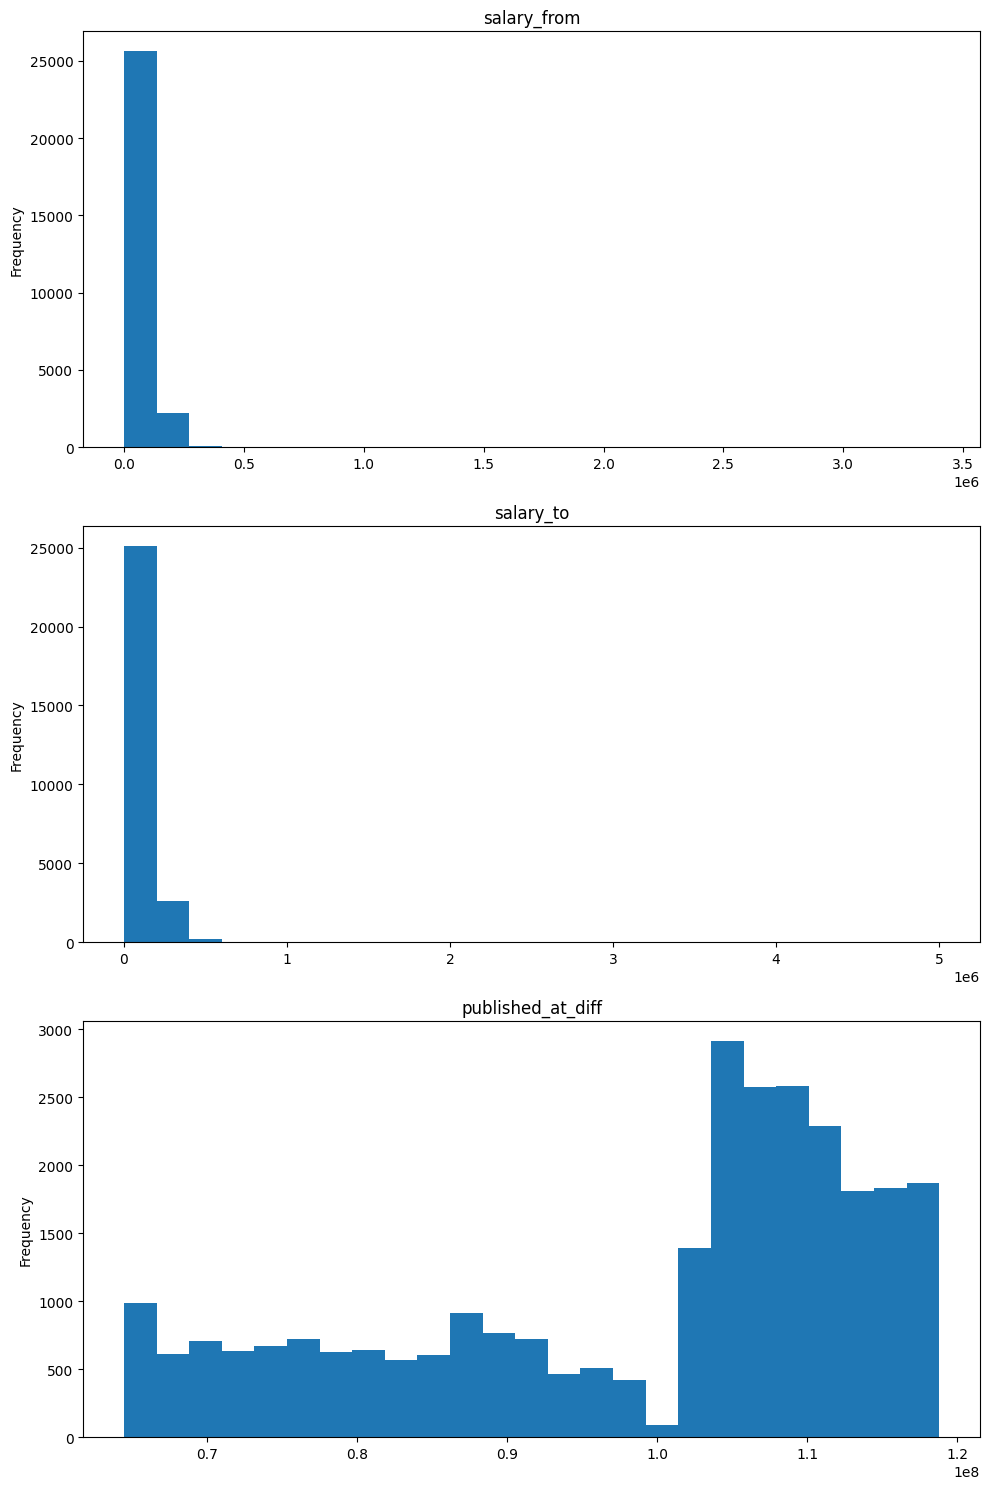

In [49]:
df_numeric = df[['salary_from', 'salary_to', 'published_at_diff']]
# Создаем гистограммы для всех столбцов
fig, axes = plt.subplots(nrows=len(df_numeric.columns), ncols=1, figsize=(10, 15))

# Проходимся по всем столбцам DataFrame и создаем гистограмму для каждого столбца
for i, column in enumerate(df_numeric.columns):
    df_numeric[column].plot(kind='hist', bins=25, ax=axes[i])
    axes[i].set_title(column)

plt.tight_layout()
plt.show()

In [50]:
df["published_at_diff"] = df["published_at_diff"] / 1e8

In [51]:
#df['published_at_diff1'] = df['published_at_diff'].map(lambda x: "Recent" if x < 0.8 else "Middle" if x >= 0.8 and x < 1.0 else "Old")
df['published_at_diff1'] = df['published_at_diff'].map(lambda x: "Recent" if x <= 1.0 else "Old")

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27934 entries, 29083 to 15795
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype              
---  ------                    --------------  -----              
 0   name                      27934 non-null  object             
 1   has_test                  27934 non-null  bool               
 2   response_letter_required  27934 non-null  bool               
 3   salary_from               27934 non-null  float64            
 4   salary_gross              27934 non-null  bool               
 5   published_at              27934 non-null  datetime64[ns, UTC]
 6   employer_name             27934 non-null  object             
 7   description               27934 non-null  int64              
 8   area_name                 27934 non-null  object             
 9   salary_to                 27934 non-null  float64            
 10  published_at_diff         27934 non-null  float64            
 11  published_at_dif

In [53]:
df['published_at_diff'] = df['published_at_diff'].astype(object)

In [54]:
df

,name,has_test,response_letter_required,salary_from,salary_gross,published_at,employer_name,description,area_name,salary_to,published_at_diff,published_at_diff1
id,,,,,,,,,,,,
29083,менеджер,False,False,64179.458874,False,2020-06-16 06:45:04+00:00,Other,-1,Москва,200000.0,1.105145,Old
26052,маркетолог,False,False,120000.000000,False,2020-07-22 10:24:15+00:00,Other,-1,Москва,170000.0,1.07391,Old
24055,разработчик,False,False,64179.458874,False,2020-04-12 08:19:08+00:00,Other,-1,Москва,120000.0,1.161249,Old
4408,продавец,False,False,33500.000000,True,2020-08-24 01:16:52+00:00,пятёрочка,-1,Москва,38000.0,1.045726,Old
16856,дизайнер,False,True,30000.000000,True,2021-09-18 13:30:15+00:00,Other,-1,Москва,35000.0,0.708326,Recent
...,...,...,...,...,...,...,...,...,...,...,...,...
16850,директор,False,False,120000.000000,False,2021-10-03 10:04:45+00:00,Other,-1,Москва,150000.0,0.695489,Recent
6265,продавец,False,False,33500.000000,True,2020-09-07 00:32:00+00:00,пятёрочка,-1,Москва,38000.0,1.033657,Old
11284,аналитик,False,False,50000.000000,False,2021-04-20 08:25:44+00:00,personname,-1,Москва,70000.0,0.838973,Recent


In [55]:
df = df.drop(columns=['published_at', 'published_at_diff'])

<H1>One-Hotting</H1>

И сделаем One-hotting фич:

In [56]:
df.dtypes

name                         object
has_test                       bool
response_letter_required       bool
salary_from                 float64
salary_gross                   bool
employer_name                object
description                   int64
area_name                    object
salary_to                   float64
published_at_diff1           object
dtype: object

In [57]:
df_one_hoted = df.copy()

ONE_HOT_COL = ['area_name', 'name', 'employer_name', 'published_at_diff1']

temp = pd.get_dummies(df_one_hoted[ONE_HOT_COL], prefix=ONE_HOT_COL, dtype=bool)

df_one_hoted = pd.concat([temp, df], axis=1)

df_one_hoted.head()

,area_name_Other,area_name_Москва,area_name_Новосибирск,area_name_Санкт-Петербург,name_Other,name_hr,name_администратор,name_аналитик,name_ассистент,name_бухгалтер,...,name,has_test,response_letter_required,salary_from,salary_gross,employer_name,description,area_name,salary_to,published_at_diff1
id,,,,,,,,,,,,,,,,,,,,,
29083,False,True,False,False,False,False,False,False,False,False,...,менеджер,False,False,64179.458874,False,Other,-1,Москва,200000.0,Old
26052,False,True,False,False,False,False,False,False,False,False,...,маркетолог,False,False,120000.000000,False,Other,-1,Москва,170000.0,Old
24055,False,True,False,False,False,False,False,False,False,False,...,разработчик,False,False,64179.458874,False,Other,-1,Москва,120000.0,Old
4408,False,True,False,False,False,False,False,False,False,False,...,продавец,False,False,33500.000000,True,пятёрочка,-1,Москва,38000.0,Old
16856,False,True,False,False,False,False,False,False,False,False,...,дизайнер,False,True,30000.000000,True,Other,-1,Москва,35000.0,Recent


In [58]:
df_one_hoted = df_one_hoted.drop(columns=['employer_name', 'name', 'area_name', 'published_at_diff1'])

In [59]:
df_one_hoted

,area_name_Other,area_name_Москва,area_name_Новосибирск,area_name_Санкт-Петербург,name_Other,name_hr,name_администратор,name_аналитик,name_ассистент,name_бухгалтер,...,employer_name_перекресток,employer_name_пятёрочка,published_at_diff1_Old,published_at_diff1_Recent,has_test,response_letter_required,salary_from,salary_gross,description,salary_to
id,,,,,,,,,,,,,,,,,,,,,
29083,False,True,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,64179.458874,False,-1,200000.0
26052,False,True,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,120000.000000,False,-1,170000.0
24055,False,True,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,64179.458874,False,-1,120000.0
4408,False,True,False,False,False,False,False,False,False,False,...,False,True,True,False,False,False,33500.000000,True,-1,38000.0
16856,False,True,False,False,False,False,False,False,False,False,...,False,False,False,True,False,True,30000.000000,True,-1,35000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16850,False,True,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,120000.000000,False,-1,150000.0
6265,False,True,False,False,False,False,False,False,False,False,...,False,True,True,False,False,False,33500.000000,True,-1,38000.0
11284,False,True,False,False,False,False,False,True,False,False,...,False,False,False,True,False,False,50000.000000,False,-1,70000.0


In [60]:
df_one_hoted.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27934 entries, 29083 to 15795
Data columns (total 52 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   area_name_Other            27934 non-null  bool   
 1   area_name_Москва           27934 non-null  bool   
 2   area_name_Новосибирск      27934 non-null  bool   
 3   area_name_Санкт-Петербург  27934 non-null  bool   
 4   name_Other                 27934 non-null  bool   
 5   name_hr                    27934 non-null  bool   
 6   name_администратор         27934 non-null  bool   
 7   name_аналитик              27934 non-null  bool   
 8   name_ассистент             27934 non-null  bool   
 9   name_бухгалтер             27934 non-null  bool   
 10  name_водитель              27934 non-null  bool   
 11  name_грузчик               27934 non-null  bool   
 12  name_дизайнер              27934 non-null  bool   
 13  name_директор              27934 non-null  bool

In [61]:
df = df_one_hoted

<H1>Корреляция</H1>

In [62]:
df.corr().style.background_gradient(cmap='coolwarm')

,area_name_Other,area_name_Москва,area_name_Новосибирск,area_name_Санкт-Петербург,name_Other,name_hr,name_администратор,name_аналитик,name_ассистент,name_бухгалтер,name_водитель,name_грузчик,name_дизайнер,name_директор,name_инженер,name_консультант,name_курьер,name_логист,name_маркетолог,name_мастер,name_медик,name_менеджер,name_мерчендайзер,name_монтажер,name_оператор,name_охрана,name_повар,name_полиция,name_продавец,name_разработчик,name_райтер,name_руководитель,name_слесарь,name_специалист,name_стажер,name_уборщик,name_учитель,name_юрист,employer_name_Other,employer_name_personname,employer_name_билайн,employer_name_мвд,employer_name_перекресток,employer_name_пятёрочка,published_at_diff1_Old,published_at_diff1_Recent,has_test,response_letter_required,salary_from,salary_gross,description,salary_to
area_name_Other,1.000000,-0.439908,-0.022528,-0.129433,-0.056317,0.092669,0.009416,-0.000203,-0.012112,0.021084,-0.025649,-0.031569,0.079845,-0.026481,-0.049466,-0.016539,-0.026482,-0.013427,-0.027395,-0.017088,-0.029041,-0.032084,-0.015940,-0.024634,-0.009840,-0.023305,-0.025748,-0.016714,-0.077006,0.202327,-0.026417,-0.028886,-0.016332,-0.004929,-0.000331,-0.040261,0.062727,-0.039689,0.062609,-0.002892,-0.021185,-0.017308,-0.028665,-0.065139,-0.335146,0.335146,0.025561,0.008134,0.023217,-0.034050,-0.003243,0.025690
area_name_Москва,-0.439908,1.000000,-0.141528,-0.813153,-0.009089,-0.038530,-0.005649,0.062463,0.014805,-0.015661,-0.018499,-0.021254,-0.043994,0.053876,0.061132,0.026641,-0.036318,-0.018960,0.043175,0.002295,0.003714,0.036405,-0.016426,0.013846,0.010995,-0.094477,-0.003689,-0.000654,-0.027051,-0.109901,0.043813,0.013107,-0.006375,0.003229,0.003375,0.064269,-0.005017,0.077600,-0.008376,0.010120,-0.029192,0.010724,-0.030213,0.025160,0.061688,-0.061688,-0.001626,0.006627,0.063912,0.004232,0.002095,0.043771
area_name_Новосибирск,-0.022528,-0.141528,1.000000,-0.041642,-0.019186,0.028063,-0.002342,-0.011144,-0.005377,0.000278,-0.008252,-0.010157,0.041891,-0.006010,-0.011976,-0.007463,-0.008520,-0.006701,-0.003920,-0.005498,-0.009755,-0.023049,-0.005128,-0.007925,-0.013088,-0.007498,-0.008284,-0.005377,-0.024947,0.097710,-0.011052,-0.012527,-0.005254,-0.008766,-0.002709,-0.012953,-0.002724,-0.013376,0.020654,-0.001096,-0.008268,-0.005568,-0.009222,-0.020957,-0.108495,0.108495,0.021338,0.000391,0.030389,-0.029064,-0.001317,0.028871
area_name_Санкт-Петербург,-0.129433,-0.813153,-0.041642,1.000000,0.049565,-0.020952,0.000923,-0.067387,-0.007828,0.004257,0.038540,0.045739,-0.009764,-0.042414,-0.034854,-0.017852,0.059060,0.031065,-0.030312,0.009315,0.016128,-0.015702,0.029467,0.001636,-0.003337,0.121936,0.022035,0.012355,0.083863,-0.024703,-0.030112,0.006113,0.018492,0.001352,-0.002990,-0.043924,-0.033103,-0.059109,-0.034278,-0.009279,0.047712,0.000036,0.053746,0.017144,0.164186,-0.164186,-0.018765,-0.012597,-0.092577,0.022822,-0.000031,-0.071262
name_Other,-0.056317,-0.009089,-0.019186,0.049565,1.000000,-0.041170,-0.054549,-0.058222,-0.019750,-0.037974,-0.030309,-0.037304,-0.040684,-0.035829,-0.066823,-0.027409,-0.031293,-0.024612,-0.046485,-0.020192,-0.035829,-0.145629,-0.018836,-0.029109,-0.048073,-0.027539,-0.030426,-0.019750,-0.091630,-0.151840,-0.040595,-0.046011,-0.019299,-0.058158,-0.027668,-0.047575,-0.043902,-0.049131,0.019325,0.026771,-0.030367,-0.006945,0.033033,-0.058021,0.159443,-0.159443,-0.023982,-0.011578,-0.065352,-0.011531,-0.004264,-0.041078
name_hr,0.092669,-0.038530,0.028063,-0.020952,-0.041170,1.000000,-0.022969,-0.024516,-0.008316,-0.015990,-0.012762,-0.015708,-0.017131,-0.015087,-0.028137,-0.011541,-0.013177,-0.010364,-0.019573,-0.008502,-0.015087,-0.061320,-0.007931,-0.012257,-0.020242,-0.011596,-0.012811,-0.008316,-0.038582,-0.063935,-0.017093,-0.019374,-0.008126,-0.024488,-0.011650,-0.020032,-0.018486,-0.020687,0.025204,0.008087,-0.012787,-0.008612,-0.014263,-0.032411,-0.122231,0.122231,0.006961,0.026428,-0.016605,-0.034073,-0.002020,0.001442
name_администратор,0.009416,-0.005649,-0.002342,0.000923,-0.

<H1>Создание модели</H1>

In [63]:
from sklearn.model_selection import train_test_split


df_sampled = df.sample(15_000)

X_train, X_test, y_train, y_test = train_test_split(df_sampled.drop(columns='salary_to'), df_sampled.salary_to, random_state=1234)

In [64]:
df_sampled.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15000 entries, 8020 to 36844
Data columns (total 52 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   area_name_Other            15000 non-null  bool   
 1   area_name_Москва           15000 non-null  bool   
 2   area_name_Новосибирск      15000 non-null  bool   
 3   area_name_Санкт-Петербург  15000 non-null  bool   
 4   name_Other                 15000 non-null  bool   
 5   name_hr                    15000 non-null  bool   
 6   name_администратор         15000 non-null  bool   
 7   name_аналитик              15000 non-null  bool   
 8   name_ассистент             15000 non-null  bool   
 9   name_бухгалтер             15000 non-null  bool   
 10  name_водитель              15000 non-null  bool   
 11  name_грузчик               15000 non-null  bool   
 12  name_дизайнер              15000 non-null  bool   
 13  name_директор              15000 non-null  bool 

In [65]:
df.salary_to.describe()

count    2.793400e+04
mean     1.044182e+05
std      1.052993e+05
min      1.000000e+01
25%      4.500000e+04
50%      7.000000e+04
75%      1.400000e+05
max      5.000000e+06
Name: salary_to, dtype: float64

In [66]:
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

In [67]:
%%time
from sklearn.linear_model import SGDRegressor, LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

model_LR = LinearRegression()
model_LR.fit(X_train, y_train)

y_pred_train = model_LR.predict(X_train)
y_pred_test = model_LR.predict(X_test)

print(f'MAE train: {mean_absolute_error(y_train, y_pred_train)}, MAE test: {mean_absolute_error(y_test, y_pred_test)}')
print(f'MSE train: {mean_squared_error(y_train, y_pred_train)}, MSE test: {mean_squared_error(y_test, y_pred_test)}')
print(f'MAPE train: {mean_absolute_percentage_error(y_train, y_pred_train)}, MAPE test: {mean_absolute_percentage_error(y_test, y_pred_test)}')
print(f'SMAPE train: {smape(y_train, y_pred_train)}, SMAPE test: {smape(y_test, y_pred_test)}')

MAE train: 33878.03206164908, MAE test: 31954.611619395913
MSE train: 6955870159.311246, MSE test: 3150597683.8033967
MAPE train: 1.1862953510076681, MAPE test: 1.1833819558168839
SMAPE train: 31.971402387068448, SMAPE test: 32.024130530951695
CPU times: user 245 ms, sys: 851 ms, total: 1.1 s
Wall time: 349 ms


In [68]:
model_SGR = SGDRegressor() # epsilon_insensitive, huber, squared_loss
model_SGR.fit(X_train, y_train)

y_pred_train = model_SGR.predict(X_train)
y_pred_test = model_SGR.predict(X_test)

print(f'MAE train: {mean_absolute_error(y_train, y_pred_train)}, MAE test: {mean_absolute_error(y_test, y_pred_test)}')
print(f'MSE train: {mean_squared_error(y_train, y_pred_train)}, MSE test: {mean_squared_error(y_test, y_pred_test)}')
print(f'MAPE train: {mean_absolute_percentage_error(y_train, y_pred_train)}, MAPE test: {mean_absolute_percentage_error(y_test, y_pred_test)}')
print(f'SMAPE train: {smape(y_train, y_pred_train)}, SMAPE test: {smape(y_test, y_pred_test)}')

MAE train: 9.880596537298198e+20, MAE test: 2.4977011523472675e+22
MSE train: 5.9824005675656955e+44, MSE test: 1.0477410981090084e+48
MAPE train: 1.4290344244251498e+16, MAPE test: 3.336237566034611e+17
SMAPE train: 200.0, SMAPE test: 200.0


In [69]:
%%time
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error


xg_model = XGBRegressor(n_estimators  = 50)
xg_model.fit(X_train, y_train)

y_pred_train = xg_model.predict(X_train)
y_pred_test = xg_model.predict(X_test)

print(f'MAE train: {mean_absolute_error(y_train, y_pred_train)}, MAE test: {mean_absolute_error(y_test, y_pred_test)}')
print(f'MSE train: {mean_squared_error(y_train, y_pred_train)}, MSE test: {mean_squared_error(y_test, y_pred_test)}')
print(f'MAPE train: {mean_absolute_percentage_error(y_train, y_pred_train)}, MAPE test: {mean_absolute_percentage_error(y_test, y_pred_test)}')
print(f'SMAPE train: {smape(y_train, y_pred_train)}, SMAPE test: {smape(y_test, y_pred_test)}')

MAE train: 26641.04845457899, MAE test: 29974.8633328125
MSE train: 3699444417.6707597, MSE test: 5456185292.455723
MAPE train: 0.8674685365851755, MAPE test: 18.092935268112253
SMAPE train: 25.445167992099368, SMAPE test: 28.01023818334728
CPU times: user 2.35 s, sys: 75.7 ms, total: 2.43 s
Wall time: 1.09 s


In [70]:
%%time
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error


model = RandomForestRegressor(n_estimators=500, criterion='friedman_mse')
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

print(f'MAE train: {mean_absolute_error(y_train, y_pred_train)}, MAE test: {mean_absolute_error(y_test, y_pred_test)}')
print(f'MSE train: {mean_squared_error(y_train, y_pred_train)}, MSE test: {mean_squared_error(y_test, y_pred_test)}')
print(f'MAPE train: {mean_absolute_percentage_error(y_train, y_pred_train)}, MAPE test: {mean_absolute_percentage_error(y_test, y_pred_test)}')
print(f'SMAPE train: {smape(y_train, y_pred_train)}, SMAPE test: {smape(y_test, y_pred_test)}')

MAE train: 21440.282468371646, MAE test: 29576.044650816908
MSE train: 3062355111.684075, MSE test: 3687054112.7602687
MAPE train: 0.6603767890051677, MAPE test: 1.4894435905483425
SMAPE train: 18.721261620155087, SMAPE test: 26.54830355493934
CPU times: user 18.8 s, sys: 27.2 ms, total: 18.8 s
Wall time: 19.7 s


<H1>Тестовая дата</H1>

In [120]:
df_test = pd.read_csv('X_test.csv', parse_dates=['published_at', 'created_at'])

In [121]:
df_test = df_test.drop(columns=['salary_currency', 'created_at', 'area_id'])

In [122]:
df_test = df_test.set_index('id')

In [123]:
df_test.description = df_test.description.map(manage_desc)
df_test.description = df_test.description.apply(lambda x: df_test.description.min() if x == -1 else x)

In [124]:
df_test['area_name'] = df_test['area_name'].map(lambda x: x if ('area_name_' + x) in df.columns else "Other")
#df_test.loc[df_test["area_name"].value_counts()[df_test["area_name"]].values < 200, "area_name"] = "Other"

In [125]:
df_test.area_name.value_counts()

area_name
Москва             6754
Санкт-Петербург    1877
Other               610
Новосибирск          71
Name: count, dtype: int64

In [127]:
df_test.employer_name = df_test.employer_name.apply(lambda x: x.lower())

In [128]:
df_test = df_test.replace(to_replace ="пятерочка", value ="пятёрочка") 

In [129]:
df_test['employer_name'] = df_test['employer_name'].map(lambda x: x if ('employer_name_' + x) in df.columns else "Other")
#df_test.loc[df_test["employer_name"].value_counts()[df_test["employer_name"]].values < 100, "employer_name"] = "Other"

In [130]:
df_test.employer_name.value_counts()

employer_name
Other          8601
пятёрочка       521
перекресток     102
билайн           88
Name: count, dtype: int64

In [131]:
df_test.name = df_test.name.apply(lambda x: x.lower())

In [132]:
df_test.name = df_test.name.apply(lambda x: 'маркетолог' if ('маркетолог' in x or 'market' in x or 'реклам' in x or 'таргетолог' in x or 'промоутер' in x or 'таркетолог' in x) else x)
df_test.name = df_test.name.apply(lambda x: 'менеджер' if ('менеджер' in x or 'manager' in x or 'manager' in x) else x)
df_test.name = df_test.name.apply(lambda x: 'бухгалтер' if ('бухгалтер' in x) else x)
df_test.name = df_test.name.apply(lambda x: 'юрист' if ('юрист' in x) else x)
df_test.name = df_test.name.apply(lambda x: 'директор' if ('директор' in x) else x)
df_test.name = df_test.name.apply(lambda x: 'разработчик' if ('разраб' in x or 'программист' in x or 'програмист' in x or 'dev' in x or 'backend' in x or 'frontend' in x or 'back-end' in x or 'front-end' in x or 'senior' in x or 'middle' in x or 'junior' in x or 'lead' in x or 'data' in x or 'верст' in x or 'architect' in x) else x)
df_test.name = df_test.name.apply(lambda x: 'продавец' if ('продавец' in x or 'кассир' in x) else x)
df_test.name = df_test.name.apply(lambda x: 'администратор' if ('администратор' in x) else x)
df_test.name = df_test.name.apply(lambda x: 'дизайнер' if ('дизайн' in x or 'design' in x or 'художник' in x or 'artist' in x) else x)
df_test.name = df_test.name.apply(lambda x: 'инженер' if ('инженер' in x or 'engineer' in x or 'инжинер' in x) else x)
df_test.name = df_test.name.apply(lambda x: 'аналитик' if ('аналитик' in x or 'analyst' in x) else x)
df_test.name = df_test.name.apply(lambda x: 'технолог' if ('технолог ' in x) else x)
df_test.name = df_test.name.apply(lambda x: 'райтер' if ('копирайтер' in x or 'перевод' in x or 'translat' in x or 'автор' in x or 'райтер' in x or 'редактор' in x or 'писатель' in x) else x)
df_test.name = df_test.name.apply(lambda x: 'медик' if ('врач' in x or 'фармацевт' in x or 'провизор' in x or 'химик' in x or 'биолог' in x or 'медиц' in x or 'стомат' in x or 'терапевт' in x or 'хирург' in x or 'медс' in x or 'психолог' in x) else x)
df_test.name = df_test.name.apply(lambda x: 'руководитель' if ('руковод' in x) else x)
df_test.name = df_test.name.apply(lambda x: 'hr' if ('hr' in x or 'рекрутер' in x or 'сорсер' in x or 'ресерчер' in x or 'кадровик' in x or 'эйчар' in x or 'интервьюер' in x or 'recruit' in x or 'researcher' in x or 'ресечер' in x) else x)
df_test.name = df_test.name.apply(lambda x: 'консультант' if ('консульт' in x) else x)
df_test.name = df_test.name.apply(lambda x: 'оператор' if ('оператор' in x) else x)
df_test.name = df_test.name.apply(lambda x: 'пекарь' if ('пекарь' in x) else x)
df_test.name = df_test.name.apply(lambda x: 'стилист' if ('стилист' in x or 'парик' in x or 'барбер' in x or 'маникюр' in x or 'педикюр' in x or 'косметолог' in x or 'визажист' in x) else x)
df_test.name = df_test.name.apply(lambda x: 'уборщик' if ('уборщик' in x or 'уборщица' in x) else x)
df_test.name = df_test.name.apply(lambda x: 'курьер' if ('курьер' in x) else x)
df_test.name = df_test.name.apply(lambda x: 'управляющий' if ('управляющ' in x or 'заведующ' in x) else x)
df_test.name = df_test.name.apply(lambda x: 'водитель' if (' водитель' in x or x.startswith('водитель')) else x)
df_test.name = df_test.name.apply(lambda x: 'учитель' if ('учитель' in x or 'препод' in x or 'педагог' in x or 'тьютор' in x or 'воспит' in x or 'репетитор' in x or 'тренер' in x) else x)
df_test.name = df_test.name.apply(lambda x: 'координатор' if ('координатор' in x or 'coordinator' in x) else x)
df_test.name = df_test.name.apply(lambda x: 'повар' if ('повар' in x or 'шеф' in x or 'пекарь' in x or 'кух' in x or 'кондитер' in x) else x)
df_test.name = df_test.name.apply(lambda x: 'бармен' if ('бар' in x) else x)
df_test.name = df_test.name.apply(lambda x: 'официант' if ('офици' in x) else x)
df_test.name = df_test.name.apply(lambda x: 'qa' if (' qa' in x or x.startswith('qa') or 'тест' in x or 'качеств' in x) else x)
df_test.name = df_test.name.apply(lambda x: 'монтажер' if ('монтаж' in x or 'видео' in x) else x)
df_test.name = df_test.name.apply(lambda x: 'фотограф' if ('фото' in x) else x)
df_test.name = df_test.name.apply(lambda x: 'охрана' if ('охран' in x) else x)
df_test.name = df_test.name.apply(lambda x: 'экономист' if ('эконом' in x) else x)
df_test.name = df_test.name.apply(lambda x: 'мерчендайзер' if ('мерчендайзер' in x or 'мерчандайзер' in x) else x)
df_test.name = df_test.name.apply(lambda x: 'сварщик' if ('сварщик' in x) else x)
df_test.name = df_test.name.apply(lambda x: 'слесарь' if ('слесарь' in x or 'механик' in x or 'токарь' in x) else x)
df_test.name = df_test.name.apply(lambda x: 'грузчик' if ('грузчик' in x or 'кладов' in x or 'склад' in x or 'комплектовщик' in x) else x)
df_test.name = df_test.name.apply(lambda x: 'отделочник' if ('отдело' in x) else x)
df_test.name = df_test.name.apply(lambda x: 'аренда' if ('аренд' in x) else x)
df_test.name = df_test.name.apply(lambda x: 'стажер' if ('стажер' in x or 'стажёр' in x) else x)
df_test.name = df_test.name.apply(lambda x: 'товаровед' if ('товар' in x) else x)
df_test.name = df_test.name.apply(lambda x: 'домработник' if ('домраб' in x or 'горнич' in x) else x)
df_test.name = df_test.name.apply(lambda x: 'недвижимость' if ('недвиж' in x) else x)
df_test.name = df_test.name.apply(lambda x: 'сборщик' if ('сбор' in x) else x)
df_test.name = df_test.name.apply(lambda x: 'логист' if ('секрет' in x or 'логист' in x or 'диспетч' in x) else x)
df_test.name = df_test.name.apply(lambda x: 'мойщик' if ('мой' in x or 'детейл' in x) else x)
df_test.name = df_test.name.apply(lambda x: 'мастер' if ('мастер' in x) else x)
df_test.name = df_test.name.apply(lambda x: 'специалист' if ('специалист' in x) else x)
df_test.name = df_test.name.apply(lambda x: 'ассистент' if ('ассистент' in x) else x)
df_test.name = df_test.name.apply(lambda x: 'архитектор' if ('архитек' in x or 'конструкт' in x) else x)
df_test.name = df_test.name.apply(lambda x: 'начальник' if ('начальн' in x) else x)
df_test.name = df_test.name.apply(lambda x: 'полиция' if ('полиц' in x or ' след' in x or x.startswith('след') or 'дпс' in x or 'мвд' in x or 'оперу' in x) else x)
df_test.name = df_test.name.apply(lambda x: 'представитель' if ('представитель' in x) else x)
df_test.name = df_test.name.apply(lambda x: 'техник' if ('техник' in x) else x)
df_test.name = df_test.name.apply(lambda x: 'сотрудник' if ('сотрудник' in x) else x)
df_test.name = df_test.name.apply(lambda x: 'упаковщик' if ('упаков' in x or 'фасов' in x) else x)
df_test.name = df_test.name.apply(lambda x: 'агент' if ('агент' in x) else x)
df_test['name'].value_counts()

name
разработчик                 1713
менеджер                    1693
продавец                     705
инженер                      405
аналитик                     319
                            ... 
аудитор бизнес-процессов       1
аудитор                        1
методист                       1
бизнес-журналист               1
обходчик объекта               1
Name: count, Length: 397, dtype: int64

In [133]:
df_test['name'] = df_test['name'].map(lambda x: x if ('name_' + x) in df.columns else "Other")
#df_test.loc[df_test["name"].value_counts()[df_test["name"]].values < 100, "name"] = "Other"

In [134]:
df_test['name'].value_counts()

name
разработчик     1713
менеджер        1693
Other            886
продавец         705
инженер          405
                ... 
логист            53
мерчендайзер      48
мастер            44
слесарь           31
полиция           31
Name: count, Length: 34, dtype: int64

In [135]:
df_test['salary_gross'] = df_test['salary_gross'].astype(bool)

In [136]:
df_test['published_at_diff'] = df_test['published_at'].map(lambda x: datetime.now().timestamp() - x.timestamp())
#df_one_hoted = df_one_hoted.drop(columns=['published_at'])
df_test["published_at_diff"] = df_test["published_at_diff"] / 1e8
df_test['published_at_diff1'] = df_test['published_at_diff'].map(lambda x: "Recent" if x <= 1.0 else "Old")
df_test = df_test.drop(columns=['published_at', 'published_at_diff'])

In [137]:
df_one_hoted_test = df_test.copy()

ONE_HOT_COL_TEST = ['area_name', 'name', 'employer_name', 'published_at_diff1']

temp_test = pd.get_dummies(df_one_hoted_test[ONE_HOT_COL_TEST], prefix=ONE_HOT_COL_TEST, dtype=bool)

df_one_hoted_test = pd.concat([temp_test, df_test], axis=1)

In [138]:
df_one_hoted_test = df_one_hoted_test.drop(columns=['employer_name', 'area_name', 'name', 'published_at_diff1'])

In [139]:
df_test = df_one_hoted_test

In [140]:
#df_test['published_at'] = df_test['published_at'].map(lambda x: datetime.now().timestamp() - x.timestamp())

In [141]:
for columnName in df_test.columns:
    print(columnName)

area_name_Other
area_name_Москва
area_name_Новосибирск
area_name_Санкт-Петербург
name_Other
name_hr
name_администратор
name_аналитик
name_ассистент
name_бухгалтер
name_водитель
name_грузчик
name_дизайнер
name_директор
name_инженер
name_консультант
name_курьер
name_логист
name_маркетолог
name_мастер
name_медик
name_менеджер
name_мерчендайзер
name_монтажер
name_оператор
name_охрана
name_повар
name_полиция
name_продавец
name_разработчик
name_райтер
name_руководитель
name_слесарь
name_специалист
name_стажер
name_уборщик
name_учитель
name_юрист
employer_name_Other
employer_name_билайн
employer_name_перекресток
employer_name_пятёрочка
published_at_diff1_Old
published_at_diff1_Recent
has_test
response_letter_required
salary_from
salary_gross
description


In [142]:
for columnName in df.columns:
    print(columnName)
    if not (columnName in df_test.columns) and (columnName != 'salary_to'):
        df_test[columnName] = [False] * df_test.shape[0]

area_name_Other
area_name_Москва
area_name_Новосибирск
area_name_Санкт-Петербург
name_Other
name_hr
name_администратор
name_аналитик
name_ассистент
name_бухгалтер
name_водитель
name_грузчик
name_дизайнер
name_директор
name_инженер
name_консультант
name_курьер
name_логист
name_маркетолог
name_мастер
name_медик
name_менеджер
name_мерчендайзер
name_монтажер
name_оператор
name_охрана
name_повар
name_полиция
name_продавец
name_разработчик
name_райтер
name_руководитель
name_слесарь
name_специалист
name_стажер
name_уборщик
name_учитель
name_юрист
employer_name_Other
employer_name_personname
employer_name_билайн
employer_name_мвд
employer_name_перекресток
employer_name_пятёрочка
published_at_diff1_Old
published_at_diff1_Recent
has_test
response_letter_required
salary_from
salary_gross
description
salary_to


In [143]:
df_test.salary_from.fillna(df_test.salary_from.mean(), inplace = True) 

In [144]:
df_test.columns

Index(['area_name_Other', 'area_name_Москва', 'area_name_Новосибирск',
       'area_name_Санкт-Петербург', 'name_Other', 'name_hr',
       'name_администратор', 'name_аналитик', 'name_ассистент',
       'name_бухгалтер', 'name_водитель', 'name_грузчик', 'name_дизайнер',
       'name_директор', 'name_инженер', 'name_консультант', 'name_курьер',
       'name_логист', 'name_маркетолог', 'name_мастер', 'name_медик',
       'name_менеджер', 'name_мерчендайзер', 'name_монтажер', 'name_оператор',
       'name_охрана', 'name_повар', 'name_полиция', 'name_продавец',
       'name_разработчик', 'name_райтер', 'name_руководитель', 'name_слесарь',
       'name_специалист', 'name_стажер', 'name_уборщик', 'name_учитель',
       'name_юрист', 'employer_name_Other', 'employer_name_билайн',
       'employer_name_перекресток', 'employer_name_пятёрочка',
       'published_at_diff1_Old', 'published_at_diff1_Recent', 'has_test',
       'response_letter_required', 'salary_from', 'salary_gross',
       'descr

In [145]:
df.columns

Index(['area_name_Other', 'area_name_Москва', 'area_name_Новосибирск',
       'area_name_Санкт-Петербург', 'name_Other', 'name_hr',
       'name_администратор', 'name_аналитик', 'name_ассистент',
       'name_бухгалтер', 'name_водитель', 'name_грузчик', 'name_дизайнер',
       'name_директор', 'name_инженер', 'name_консультант', 'name_курьер',
       'name_логист', 'name_маркетолог', 'name_мастер', 'name_медик',
       'name_менеджер', 'name_мерчендайзер', 'name_монтажер', 'name_оператор',
       'name_охрана', 'name_повар', 'name_полиция', 'name_продавец',
       'name_разработчик', 'name_райтер', 'name_руководитель', 'name_слесарь',
       'name_специалист', 'name_стажер', 'name_уборщик', 'name_учитель',
       'name_юрист', 'employer_name_Other', 'employer_name_personname',
       'employer_name_билайн', 'employer_name_мвд',
       'employer_name_перекресток', 'employer_name_пятёрочка',
       'published_at_diff1_Old', 'published_at_diff1_Recent', 'has_test',
       'response_letter

In [146]:
columns = df.columns.tolist();
columns.remove('salary_to');
df_test = df_test[columns]

In [147]:
y_pred_test1 = model.predict(df_test)

In [148]:
df_test_full = df_test.assign(salary_to = y_pred_test1)

In [149]:
df_output = pd.concat([df_test_full['salary_to']])
df_output

id
20978     41734.524603
3102      30620.008114
14731    280025.483871
16113    248524.243082
8410     126819.696866
             ...      
29490     69556.799949
34298     63112.603666
33921     39337.298052
8886     176611.837263
23978     38724.862338
Name: salary_to, Length: 9312, dtype: float64

In [150]:
from pathlib import Path  
filepath = Path('y_test.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
df_output.to_csv(filepath)  